In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(os.path.join(dirname))

/kaggle/input
/kaggle/input/melanoma-image-insights
/kaggle/input/siim-isic-melanoma-classification
/kaggle/input/siim-isic-melanoma-classification/train
/kaggle/input/siim-isic-melanoma-classification/tfrecords
/kaggle/input/siim-isic-melanoma-classification/jpeg
/kaggle/input/siim-isic-melanoma-classification/jpeg/train
/kaggle/input/siim-isic-melanoma-classification/jpeg/test
/kaggle/input/siim-isic-melanoma-classification/test


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
import cv2
import tensorflow as tf
from functools import partial
import sklearn
from tqdm import tqdm_notebook as tqdm
import gc
%matplotlib inline

In [3]:
gpu = tf.config.experimental.list_physical_devices('GPU')
print(gpu) # to confirm that TensorFlow is using the GPU.
print("Number of GPU/s = ",len(gpu))
print("Tensorflow version = ", tf.__version__)

[]
Number of GPU/s =  0
Tensorflow version =  2.2.0


In [4]:
train = pd.DataFrame(pd.read_csv("../input/siim-isic-melanoma-classification/train.csv"))
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [5]:
test = pd.DataFrame(pd.read_csv("../input/siim-isic-melanoma-classification/test.csv"))
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     10982 non-null  object 
 1   patient_id                     10982 non-null  object 
 2   sex                            10982 non-null  object 
 3   age_approx                     10982 non-null  float64
 4   anatom_site_general_challenge  10631 non-null  object 
dtypes: float64(1), object(4)
memory usage: 429.1+ KB


In [8]:
train_image_stats_01 = pd.DataFrame(pd.read_csv("../input/melanoma-image-insights/melanoma_image_statistics_compiled_01"))
train_image_stats_02 = pd.DataFrame(pd.read_csv("../input/melanoma-image-insights/melanoma_image_statistics_compiled_02"))
train_image_stats_03 = pd.DataFrame(pd.read_csv("../input/melanoma-image-insights/melanoma_image_statistics_compiled_03"))
train_image_stats_04 = pd.DataFrame(pd.read_csv("../input/melanoma-image-insights/melanoma_image_statistics_compiled_04"))
train_image_stats_05 = pd.DataFrame(pd.read_csv("../input/melanoma-image-insights/melanoma_image_statistics_compiled_05"))
train_image_stats_06 = pd.DataFrame(pd.read_csv("../input/melanoma-image-insights/melanoma_image_statistics_compiled_06"))

print(train_image_stats_01.shape)
print(train_image_stats_02.shape)
print(train_image_stats_03.shape)
print(train_image_stats_04.shape)
print(train_image_stats_05.shape)
print(train_image_stats_06.shape)

(5000, 11)
(5000, 11)
(5000, 11)
(5000, 11)
(5000, 11)
(8126, 11)


In [9]:
train_image_statistics = pd.concat([train_image_stats_01, train_image_stats_02, train_image_stats_03,
                                   train_image_stats_04, train_image_stats_05, train_image_stats_06],
                                  ignore_index = True)
train_image_statistics.shape

(33126, 11)

In [10]:
train_image_statistics.head()

,image_name,path,rows,columns,channels,image_mean,image_standard_deviation,image_skewness,mean_red_value,mean_green_value,mean_blue_value
0,ISIC_2637011.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,4000,6000,3,169.862452,41.270046,-0.129492,212.933646,138.914514,157.739197
1,ISIC_0015719.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,4000,6000,3,171.084778,41.994142,-0.205430,217.279705,165.095320,130.879309
2,ISIC_0052212.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,1053,1872,3,158.691048,37.364873,-0.551454,199.940391,130.224750,145.908002
3,ISIC_0068279.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,1053,1872,3,80.342856,44.885518,0.453018,119.689502,62.614801,58.724265
4,ISIC_0074268.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,4000,6000,3,183.955453,37.497829,-0.157002,226.269270,173.175601,152.421488


In [11]:
train_image_statistics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   image_name                33126 non-null  object 
 1   path                      33126 non-null  object 
 2   rows                      33126 non-null  int64  
 3   columns                   33126 non-null  int64  
 4   channels                  33126 non-null  int64  
 5   image_mean                33126 non-null  float64
 6   image_standard_deviation  33126 non-null  float64
 7   image_skewness            33126 non-null  float64
 8   mean_red_value            33126 non-null  float64
 9   mean_green_value          33126 non-null  float64
 10  mean_blue_value           33126 non-null  float64
dtypes: float64(6), int64(3), object(2)
memory usage: 2.8+ MB


In [12]:
#dataset = train_image_statistics.copy()
#dataset.head()

In [13]:
"""
dataset.drop(["rows", "columns", "channels", "image_mean", "image_standard_deviation", "image_skewness",
            "mean_red_value", "mean_green_value", "mean_blue_value"], axis = 1, inplace = True)
"""

'\ndataset.drop(["rows", "columns", "channels", "image_mean", "image_standard_deviation", "image_skewness",\n            "mean_red_value", "mean_green_value", "mean_blue_value"], axis = 1, inplace = True)\n'

In [14]:
"""
labels = []
for name in tqdm(dataset["image_name"]) : 
    name = name.split(".")[0]
    segment = train[train["image_name"] == name]
    label = segment["target"].values[0]
    labels.append(label)
"""

'\nlabels = []\nfor name in tqdm(dataset["image_name"]) : \n    name = name.split(".")[0]\n    segment = train[train["image_name"] == name]\n    label = segment["target"].values[0]\n    labels.append(label)\n'

In [15]:
#dataset["target"] = labels
# dataset.to_csv("siim-isic-train-path-target.csv", index = False, header = True)

In [16]:
dataset = pd.DataFrame(pd.read_csv("../input/melanoma-image-insights/siim-isic-train-path-target.csv"))
print("Shape of the dataframe = ", dataset.shape)

Shape of the dataframe =  (33126, 3)


In [17]:
dataset.head()

,image_name,path,target
0,ISIC_2637011.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,0
1,ISIC_0015719.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,0
2,ISIC_0052212.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,0
3,ISIC_0068279.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,0
4,ISIC_0074268.jpg,/kaggle/input/siim-isic-melanoma-classificatio...,0


We split in train and val.

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit
split_object = StratifiedShuffleSplit(n_splits = 1, test_size = 0.17, random_state = 42)
for train_index, val_index in split_object.split(dataset, dataset["target"]) : 
    training_set = dataset.loc[train_index]
    validation_set = dataset.loc[val_index]

print("Shape of training set = ", training_set.shape)
print("Shape of validation set = ", validation_set.shape)

Shape of training set =  (27494, 3)
Shape of validation set =  (5632, 3)


Observing the distribution

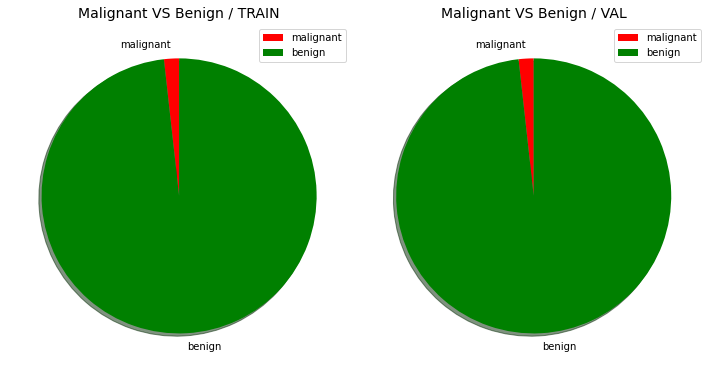

In [19]:
train_malignant = len(training_set[training_set["target"] == 1])
train_benign = len(training_set[training_set["target"] == 0])
val_malignant = len(validation_set[validation_set["target"] == 1])
val_benign = len(validation_set[validation_set["target"] == 0])

labels = ["malignant", "benign"]
size_train = [train_malignant, train_benign]
size_val = [val_malignant, val_benign]

plt.figure(figsize = (10, 10))
plt.subplot(1,2,1)
plt.pie(size_train, labels = labels, shadow = True, startangle = 90, colors = ["r", "g"])
plt.title("Malignant VS Benign / TRAIN", fontsize = 14)
plt.legend()

plt.subplot(1,2,2)
plt.pie(size_val, labels = labels, shadow = True, startangle = 90, colors = ["r", "g"])
plt.title("Malignant VS Benign / VAL", fontsize = 14)
plt.legend()

plt.tight_layout()

In [20]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0)

In [21]:
train_generator = datagen.flow_from_dataframe(dataframe = training_set, directory = "../input/siim-isic-melanoma-classification/jpeg/",
                                             x_col = "path", y_col = "target", batch_size = 32, seed = 42,
                                             shuffle = True, class_mode = "raw", target_size = (256, 256))

Found 27494 validated image filenames.


In [22]:
validation_generator = datagen.flow_from_dataframe(dataframe = validation_set, directory = "../input/siim-isic-melanoma-classification/jpeg/",
                                             x_col = "path", y_col = "target", batch_size = 32, seed = 42,
                                             shuffle = True, class_mode = "raw", target_size = (256, 256))

Found 5632 validated image filenames.
